<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

***Some parts of the notebook are almost the exact copy of***  https://github.com/yandexdataschool/nlp_course

##  Attention

Attention layer can take in the previous hidden state of the decoder $s_{t-1}$, and all of the stacked forward and backward hidden states $H$ from the encoder. The layer will output an attention vector $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far $s_{t-1}$, and all of what we have encoded $H$, to produce a vector $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode $\hat{y}_{t+1}$. The decoder input word that has been embedded  $y_t$.

You can use any type of the attention scores between previous hidden state of the encoder $s_{t-1}$ and hidden state of the decoder $h \in H$, you prefer. We have met at least three of them:<br><br>

$$\operatorname{score}\left(\boldsymbol{h}, \boldsymbol{s}_{t-1}\right)=\left\{\begin{array}{ll}
\boldsymbol{h}^{\top} \boldsymbol{s}_{t-1} & \text { dot } \\
\boldsymbol{h}^{\top} \boldsymbol{W}_{\boldsymbol{a}} \boldsymbol{s}_{t-1} & \text { general } \\
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{\boldsymbol{a}}\left[\boldsymbol{h} ; \boldsymbol{s}_{t-1}\right]\right) & \text { concat }
\end{array}\right.$$
--------


**_We wil use "concat attention"_**:

First, we calculate the *energy* between the previous decoder hidden state $s_{t-1}$ and the encoder hidden states $H$. As our encoder hidden states $H$ are a sequence of $T$ tensors, and our previous decoder hidden state $s_{t-1}$ is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. $\Rightarrow$<br>
We have:<br>
$$H = \bigl[\boldsymbol{h}_{0}, ..., \boldsymbol{h}_{T-1}\bigr] \\ \bigl[\boldsymbol{s}_{t-1}, ..., \boldsymbol{s}_{t-1}\bigr]$$

The encoder hidden dim and the decoder hidden dim should be equal: **dec hid dim = enc hid dim**.<br>
 We then calculate the energy, $E_t$, between them by concatenating them together:<br>

$$\bigl[[\boldsymbol{h}_{0}, \boldsymbol{s}_{t-1}], ..., [\boldsymbol{h}_{T-1}, \boldsymbol{s}_{t-1}]\bigr]$$

And passing them through a linear layer (`attn` = $\boldsymbol{W}_{\boldsymbol{a}}$) and a $\tanh$ activation function:

$$E_t = \tanh(\text{attn}(H, s_{t-1}))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[enc hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, enc hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$


We can think of this as calculating a weighted sum of the "match" over all `enc_hid_dem` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

### Temperature SoftMax

<img src="https://miro.medium.com/max/793/1*S5X1pBq_jfDreJOs7yP-ZQ.png" height=100>

This gives us the attention over the source sentence!

Graphically, this looks something like below. $z = s_{t-1}$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.


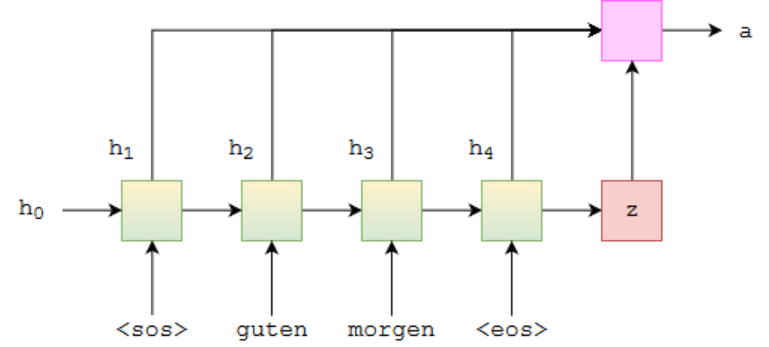

# Neural Machine Translation

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
! wget https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ -O data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

--2021-11-07 10:01:40--  https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving drive.google.com (drive.google.com)... 209.85.147.138, 209.85.147.139, 209.85.147.113, ...
Connecting to drive.google.com (drive.google.com)|209.85.147.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/auusr8pcj02id6i4r04nfbhlkssvevkr/1636279275000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ [following]
--2021-11-07 10:01:40--  https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/auusr8pcj02id6i4r04nfbhlkssvevkr/1636279275000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)... 142.250.103.132, 2607:f8b0:4001:c56::84
Connecting to doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)|142.2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time
import numpy as np

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

We'll set the random seeds for deterministic results.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preparing Data

Here comes the preprocessing

In [4]:
tokenizer_W = WordPunctTokenizer()

def tokenize_ru(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())[::-1]

def tokenize_en(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [45]:
tokenize_ru("Привет, как дела")

['дела', 'как', ',', 'привет']

In [5]:
SRC = Field(tokenize=tokenize_ru,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


dataset = torchtext.legacy.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
print(len(dataset.examples))
print(dataset.examples[0].src)
print(dataset.examples[0].trg)

50000
['.', 'собора', 'троицкого', '-', 'свято', 'от', 'ходьбы', 'минутах', '3', 'в', ',', 'тбилиси', 'в', 'расположен', 'cordelia', 'отель']
['cordelia', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.']


In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [9]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 14129
Unique tokens in target (en) vocabulary: 10104


And here is example from train dataset:

In [10]:
print(vars(train_data.examples[9]))

{'trg': ['other', 'facilities', 'offered', 'at', 'the', 'property', 'include', 'grocery', 'deliveries', ',', 'laundry', 'and', 'ironing', 'services', '.'], 'src': ['.', 'услуги', 'гладильные', 'и', 'прачечной', 'услуги', ',', 'продуктов', 'доставка', 'предлагается', 'также']}


When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
!nvidia-smi

Sun Nov  7 10:02:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    31W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

## Let's use modules.py

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
%cd /content/drive/MyDrive/Colab Notebooks/Attention

/content/drive/MyDrive/Colab Notebooks/Attention


In [16]:
%ls

 best-val-model.pt                           modules.py
'[homework]NeuralMachineTranslation.ipynb'   __pycache__/


In [18]:
%cd ./drive/MyDrive/Colab Notebooks/Attention/modules.py

[Errno 2] No such file or directory: './drive/MyDrive/Colab Notebooks/Attention/modules.py'
/content/drive/MyDrive/Colab Notebooks/Attention


## Encoder

For a multi-layer RNN, the input sentence, $X$, goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. Thus, representing each layer with a superscript, the hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(x_t, h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Extending our multi-layer equations to LSTMs, we get:

$$\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(x_t, (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$

<br><br>
<img src="https://drive.google.com/uc?id=1uIUxtZU8NvGdz0J9BlRSTbsBLFh32rxx">

In [19]:
# you can paste code of encoder from modules.py
# the encoder can be like seminar encoder but you have to return outputs
# and if you use bidirectional you won't make the same operation like with hidden
# because outputs = [src sent len, batch size, hid dim * n directions]
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, bidirectional):
        super().__init__()
        
        self.input_dim = input_dim          # source vocab size
        self.emb_dim = emb_dim              # vector length for each token
        self.hid_dim = hid_dim              # hidden dim of the RNN
        self.n_layers = n_layers            # num LSTM layers
        self.dropout = dropout              # prob of zeroing out units
        self.bidirectional = bidirectional  # bool, if the RNN will be biderectional
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        
        outputs, (hidden, cell) = self.rnn(embedded)
        #print("outputs.shape\n\t", outputs.shape)
        
        #outputs = [src sent len, batch size, hid dim * n directions]

        #hidden = [n layers * n directions, batch size, hid dim]  | for n directions = 1
        #       = [n layers, batch size, hid dim]                 | for n directions = 1
        #       = [n layers, batch size, hid dim * n directions]
        #cell = [n layers * n directions, batch size, hid dim]    | for n directions = 1
        #     = [n layers, batch size, hid dim]                   | for n directions = 1
        #     = [n layers, batch size, hid dim * n directions]
        
        
        #outputs are always from the top hidden layer
        if self.bidirectional:
            #print("hidden.shape before adjustment\n\t", hidden.shape)
            hidden = hidden.reshape(self.n_layers, 2, -1, self.hid_dim)
            hidden = hidden.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)
            #print("hidden.shape after adjustment\n\t", hidden.shape)

            #print("cell.shape before adjustment\n\t", cell.shape)
            cell = cell.reshape(self.n_layers, 2, -1, self.hid_dim)
            cell = cell.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)
            #print("cell.shape after adjustment\n\t", cell.shape)


        # in both cases biderectional=True/False we get the followong shapes
        #   hidden = [n layers, batch size, hid dim * n directions]
        #   cell = [n layers, batch size, hid dim * n directions]
        return outputs, hidden, cell

## Attention

$$\operatorname{score}\left(\boldsymbol{h}, \boldsymbol{s}_{t-1}\right)=
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{\boldsymbol{a}}\left[\boldsymbol{h} ; \boldsymbol{s}_{t-1}\right]\right) \text { - concat attention}$$

In [20]:
# you can paste code of attention from modules.py

# def softmax(x, temperature=10): # use your temperature
#     e_x = torch.exp(x / temperature)
#     return e_x / torch.sum(e_x, dim=0)


# use your temperature
def softmax(x, temperature):
    e_x = torch.exp(x / temperature)
    return e_x / torch.sum(e_x, dim=0)




class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, softmax_temp=1):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear(enc_hid_dim + dec_hid_dim, enc_hid_dim)
        self.v = nn.Linear(enc_hid_dim, 1)

        # defaults to 1 (the usual softmax w/o temperature)
        self.softmax_temp = softmax_temp
        
    def forward(self, hidden, encoder_outputs):
        
        # encoder_outputs = [src sent len, batch size, enc_hid_dim]

        # only take the last layer of the decoder's hidden units
        # hidden = [n_layers, batch size, dec_hid_dim]
        last_hidden = hidden[-1, :, :].unsqueeze(0)
        # last_hidden = [1, batch size, dec_hid_dim] 
        
        # repeat hidden and concatenate it with encoder_outputs
        hiddens = last_hidden.repeat(encoder_outputs.shape[0], 1, 1)
        # hiddens = [src sent len, batch size, dec_hid_dim]

        #print("encoder_outputs.shape:", encoder_outputs.shape)
        #print("hiddens.shape:", hiddens.shape)

        concat_h_s = torch.cat([hiddens, encoder_outputs], dim=2)
        #print("concat_h_s.shape.shape:", concat_h_s.shape)
        #print("(self.enc_hid_dim + self.dec_hid_dim).shape:", self.enc_hid_dim + self.dec_hid_dim)
        # concat_h_s = [src sent len, batch size, enc_hid_dim + dec_hid_dim]

        # calculate energy: E
        E = torch.tanh(self.attn(concat_h_s))
        # E = [src sent len, batch size, enc_hid_dim] (see self.attn)

        # get attention (not normalized to probabilities yet)
        a = self.v(E)
        # a = [src sent len, batch size, 1]

        # use softmax function which is defined, can change temperature
        return softmax(a, temperature=self.softmax_temp)

In [21]:
# src sent len = 3
# batch_size = 8
# enc_hid_dim = 2
# dec_hid_dim = 3

d = torch.ones(3, 8, 2) * 2     # encoder_outputs = [src sent len, batch size, enc_hid_dim]
c = torch.ones(10, 8, 3)         # hidden = [n_layers, batch size, dec_hid_dim]

print(c[-1,:, :].shape)

c[-1,:, :].unsqueeze(0).shape

torch.Size([8, 3])


torch.Size([1, 8, 3])

## Decoder with Attention

To make it really work you should also change the`Decoder` class from the classwork in order to make it to use `Attention`. 
You may just copy-paste `Decoder` class and add several lines of code to it.

The decoder contains the attention layer `attention`, which takes the previous hidden state $s_{t-1}$, all of the encoder hidden states $H$, and returns the attention vector $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word that has been embedded $y_t$, the weighted source vector $w_t$, and the previous decoder hidden state $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}([y_t, w_t], s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the **first** word in an example translation.

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block is $z = s_{t-1} = s_0$, the blue block shows the decoder RNN which outputs $s_t = s_1$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

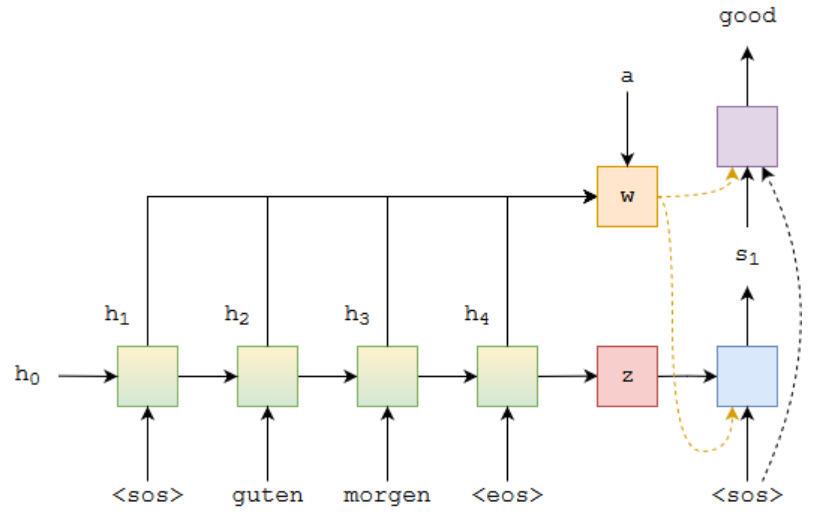

### Teacher forcing

Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.

<img src="https://miro.medium.com/max/421/1*U3d8D_GnfW13Y3nDgvwJSw.png">

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference (i.e. real world usage) it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.



In [22]:
# you can paste code of decoder from modules.py


class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim,
                 n_layers, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim        # vocab size in the target language (hence output)
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        
        # use GRU: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        self.rnn = nn.GRU(input_size=emb_dim + enc_hid_dim, # see blue box on the image
                          hidden_size=dec_hid_dim,
                          num_layers=n_layers, dropout=dropout)
        
        # linear layer to get next word: f(y_t, w_t, s_t)
        # see purple box on the image
        self.out = nn.Linear(in_features=emb_dim + enc_hid_dim + dec_hid_dim,
                             out_features=output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, dec_hid_dim]
        # print(encoder_outputs.shape)
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, dec_hid_dim]
        
        # input: [batch size] -> [1, batch size]
        input = input.unsqueeze(0) # because only one word, seq_len=1

        # Compute an embedding from the input data and apply dropout to it        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
                
        # get weighted sum of (encoder_outputs = [src sent len, batch size, enc_hid_dim])
        a = self.attention(hidden, encoder_outputs)     # a = [src sent len, batch size, 1]
        weighted = torch.bmm(a.permute(1, 2, 0),        # [batch size, 1, src sent len]
                      encoder_outputs.transpose(0, 1)   # [batch size, src sent len, enc_hid_dim]
                      ).transpose(0, 1) # w = [batch size, 1, enc_hid_dim] -> [1, batch size, enc_hid_dim]

        # print("embedded.shape:", embedded.shape)
        # print("w.shape:", w.shape)

        # concatenate weighted sum and embedded, break through the GRU
        # embedded  = [1, batch size, emb dim]
        # weighted  = [1, batch size, enc_hid_dim]
        output, hidden = self.rnn(torch.cat([embedded, weighted], dim=2), hidden)
        # output    = [1, batch size, dec_hid_dim]
        # hidden    = [n layers, batch size, dec_hid_dim]
        #   so if we want to use hidden in prediction, we need to get the last layer:
        #   hidden[-1,:,:] = [batch size, dec_hid_dim]

        
        # need the dimentions to agree for torch.cat() to work
        #
        # torch.cat([embedded, weighted, output], dim=2).squeeze(0)
        #   = [batch size, emb_dim + enc_hid_dim + dec_hid_dim] = 
        # torch.cat([embedded, weighted, hidden[-1,:,:].unsqueeze(0)], dim=2).squeeze(0)
        #   =
        # torch.cat([embedded.squeeze(0), weighted.squeeze(0), hidden[-1,:,:]], dim=1)

        # get predictions
        #
        # my initial version:
        # prediction = self.out(torch.cat([embedded, weighted, output], dim=2).squeeze(0))
        #
        # original paper version:
        prediction = self.out(torch.cat([embedded, # [1, batch size, emb dim]
                                         weighted, # [1, batch size, enc_hid_dim]
                                         # hidden[-1,:,:].unsqueeze(0) = [1, batch size, dec_hid_dim]
                                         hidden[-1,:,:].unsqueeze(0)], dim=2).squeeze(0))
        #prediction = [batch size, output dim]
        
        # will be used as arguments again:
        #   (part of input (top1 or teacher forced correct), hidden)
        return prediction, hidden

## Seq2Seq

Main idea:
* $w_t = a_t H$

* $s_t = \text{DecoderGRU}([y_t, w_t], s_{t-1})$

* $\hat{y}_{t+1} = f(y_t, w_t, s_t)$

**Note**: our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Later on when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

In [23]:
# you can paste code of seq2seq from modules.py

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim * (1 + encoder.bidirectional) == decoder.dec_hid_dim, \
                "Hidden dimensions of encoder and decoder must be equal!"
        # assert encoder.n_layers == decoder.n_layers, \
        #     "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        # src = [src sent len, batch size]
        # trg = [trg sent len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        trg_len = trg.shape[0]      # trg = [trg sent len, batch size]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        encoder_outputs, hidden, cell = self.encoder(src)
        #print('Shapes for encoder_outputs, hidden, cell')
        #print(encoder_outputs.shape, hidden.shape, cell.shape, '\n')
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):

            # insert input token embedding, previous hidden, and encoder_outputs
            # receive output tensor (predictions) and new hidden
            output, hidden = self.decoder(input, hidden, encoder_outputs)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(-1) 
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

## Training

In [24]:
# For reloading 
import modules
import imp
imp.reload(modules)

Encoder = modules.Encoder
Attention = modules.Attention
Decoder = modules.DecoderWithAttention
Seq2Seq = modules.Seq2Seq

In [25]:
INPUT_DIM = len(SRC.vocab)                          # 30,000
OUTPUT_DIM = len(TRG.vocab)                         # 30,000
ENC_EMB_DIM = 256                                   # 620
DEC_EMB_DIM = 256                                   # 620
DEC_HID_DIM = 512                                   # 1000
N_LAYERS = 2                                        # improvement (default = 1) 
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
BIDIRECTIONAL = True                                # True
ENC_HID_DIM = DEC_HID_DIM // (1 + BIDIRECTIONAL)    # 1000 fwd + 1000 bwd = 2000

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT, BIDIRECTIONAL)

# we do not give encoder's bidirectional argument to attention and decoder, but need to do it somewhere
att = Attention(enc_hid_dim=ENC_HID_DIM*(1+BIDIRECTIONAL), dec_hid_dim=DEC_HID_DIM, softmax_temp=5)
dec = DecoderWithAttention(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM*(1+BIDIRECTIONAL), DEC_HID_DIM, N_LAYERS, DEC_DROPOUT, att)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [26]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14129, 256)
    (rnn): LSTM(256, 256, num_layers=2, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=True)
    )
    (embedding): Embedding(10104, 256)
    (rnn): GRU(768, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=1280, out_features=10104, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 25,846,905 trainable parameters


__Let's take a look at our network quality__:

## Bleu

[link](https://www.aclweb.org/anthology/P02-1040.pdf)

<img src="https://drive.google.com/uc?id=1umJF2S8PiayxD9Xo8xvjW8QsrSLidozD" height=400>

In [36]:
def cut_on_eos(tokens_iter):
    for token in tokens_iter:
        if token == '<eos>':
            break
        yield token

def remove_tech_tokens(tokens_iter, tokens_to_remove=['<sos>', '<unk>', '<pad>']):
    return [x for x in tokens_iter if x not in tokens_to_remove]

def generate_translation(src, trg, model, TRG_vocab, SRC_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output[1:].argmax(-1)

    source = remove_tech_tokens(cut_on_eos([SRC_vocab.itos[x] for x in list(src[:,0].cpu().numpy())]))
    original = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[x] for x in list(trg[:,0].cpu().numpy())]))
    generated = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[x] for x in list(output[:, 0].cpu().numpy())]))
    
    print('Source: {}'.format(' '.join(source[::-1])))
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

def get_text(x, vocab):
     generated = remove_tech_tokens(cut_on_eos([vocab.itos[elem] for elem in list(x)]))
     return generated

In [29]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(tqdm.notebook.tqdm(iterator)):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, OUTPUT_DIM)
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
            
    return history, (epoch_loss / len(iterator))

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm.notebook.tqdm(iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, OUTPUT_DIM)
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


def evaluate_bleu(model, iterator, TRG_vocab):
    original_text = []
    generated_text = []

    model.eval()  
    with torch.no_grad():
        for i, batch in enumerate(tqdm.notebook.tqdm(iterator)):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].argmax(-1)
            
            original_text.extend([get_text(x, TRG_vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG_vocab) for x in output.detach().cpu().numpy().T])
            # original_text = flatten(original_text)
            # generated_text = flatten(generated_text)
        return corpus_bleu([[text] for text in original_text], generated_text) * 100

    

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters()) # ORIGINAL: SGD together with Adadelta
sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [31]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [32]:
FROM_PRETRAINED = False

In [33]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

#model.apply(init_weights)

if FROM_PRETRAINED:
    try:
        # Make sure the following line is in the detector.
        # prediction = self.out(torch.cat([embedded, weighted, output], dim=2).squeeze(0))
        model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Attention/best-val-model.pt'))
        print('Loaded pre-trained model.')
    except FileNotFoundError as e:
        print(e)
        model.apply(init_weights)
        print('\nInitialized the weights randomly: Uniform distrubution (-0.08, 0.08).')

else:
    model.apply(init_weights)
    print('\nInitialized the weights randomly: Uniform distrubution (-0.08, 0.08).')


Initialized the weights randomly: Uniform distrubution (-0.08, 0.08).


In [34]:
TRAIN = True

Calculating valid bleu of the best checkpoint.


  0%|          | 0/20 [00:00<?, ?it/s]

Best valid bleu achieved: 8.0

 -------------------------------------------------------------------------------- 

Epoch: 01
Calculating train_loss


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

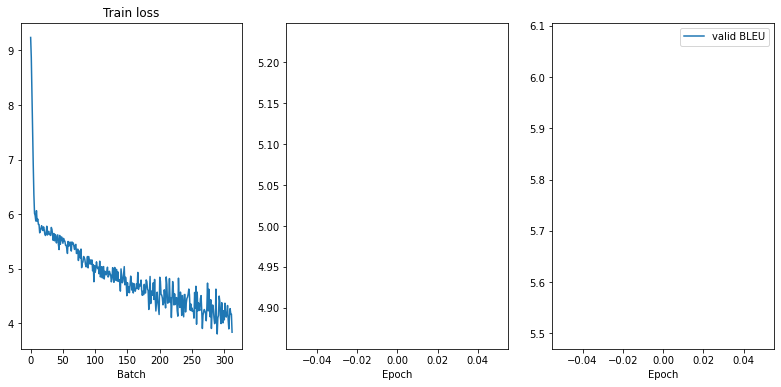

Epoch: 01 | Time: 8m 22s
	Train Loss: 4.868 | Train PPL: 130.081
	 Val. Loss: 5.230 |  Val. PPL: 186.800
	 Val. BLEU: 5.788

 -------------------------------------------------------------------------------- 

Epoch: 02
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

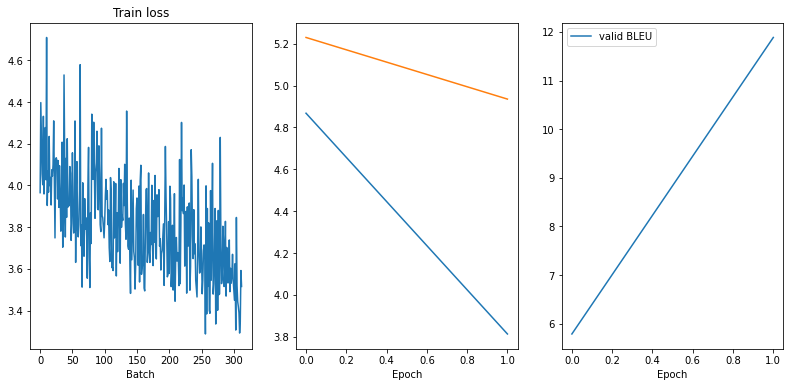

Epoch: 02 | Time: 8m 22s
	Train Loss: 3.813 | Train PPL:  45.308
	 Val. Loss: 4.936 |  Val. PPL: 139.160
	 Val. BLEU: 11.885

 -------------------------------------------------------------------------------- 

Epoch: 03
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

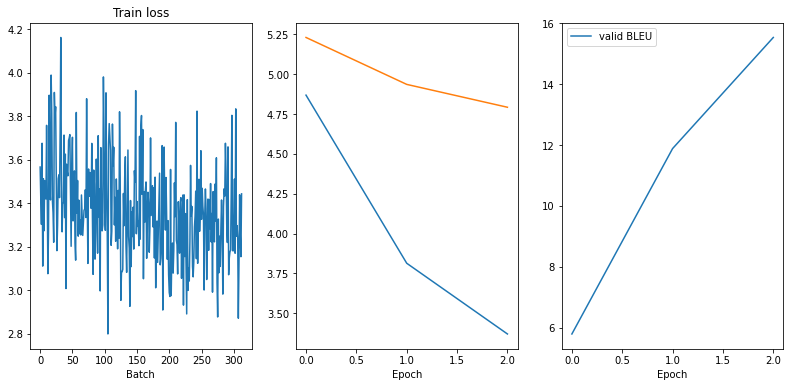

Epoch: 03 | Time: 8m 24s
	Train Loss: 3.370 | Train PPL:  29.072
	 Val. Loss: 4.792 |  Val. PPL: 120.568
	 Val. BLEU: 15.538

 -------------------------------------------------------------------------------- 

Epoch: 04
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

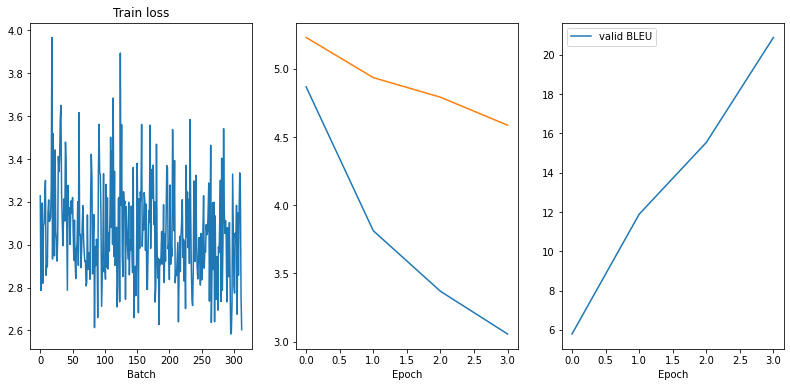

Epoch: 04 | Time: 8m 24s
	Train Loss: 3.057 | Train PPL:  21.254
	 Val. Loss: 4.587 |  Val. PPL:  98.204
	 Val. BLEU: 20.886

 -------------------------------------------------------------------------------- 

Epoch: 05
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

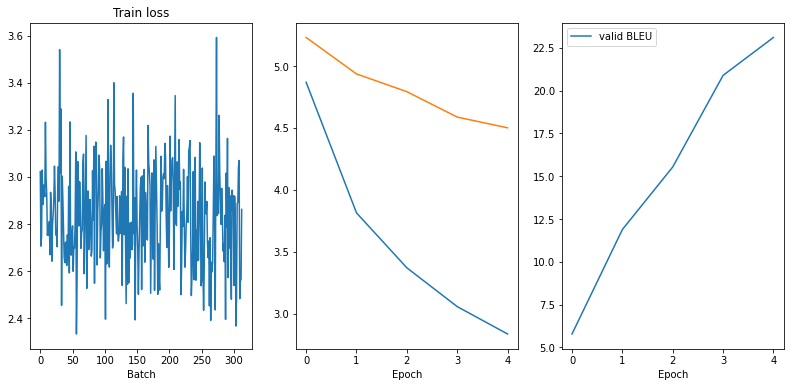

Epoch: 05 | Time: 8m 26s
	Train Loss: 2.835 | Train PPL:  17.037
	 Val. Loss: 4.500 |  Val. PPL:  90.056
	 Val. BLEU: 23.100

 -------------------------------------------------------------------------------- 

Epoch: 06
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

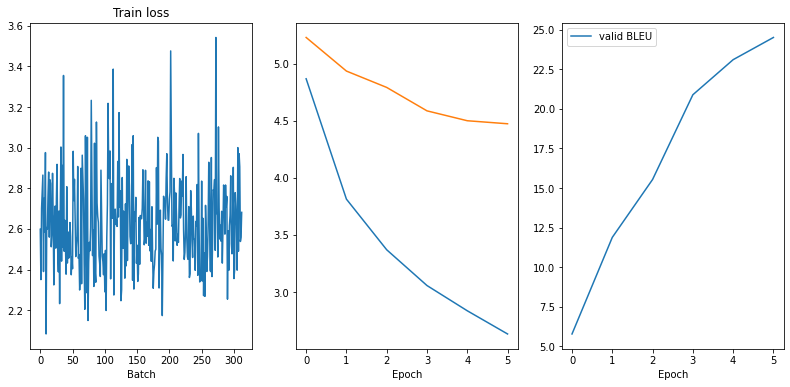

Epoch: 06 | Time: 8m 27s
	Train Loss: 2.632 | Train PPL:  13.903
	 Val. Loss: 4.474 |  Val. PPL:  87.702
	 Val. BLEU: 24.502

 -------------------------------------------------------------------------------- 

Epoch: 07
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

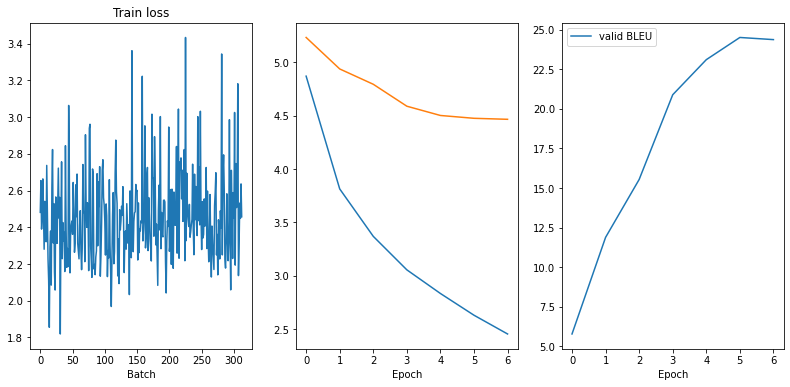

Epoch: 07 | Time: 8m 20s
	Train Loss: 2.457 | Train PPL:  11.667
	 Val. Loss: 4.465 |  Val. PPL:  86.888
	 Val. BLEU: 24.367

 -------------------------------------------------------------------------------- 

Epoch: 08
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

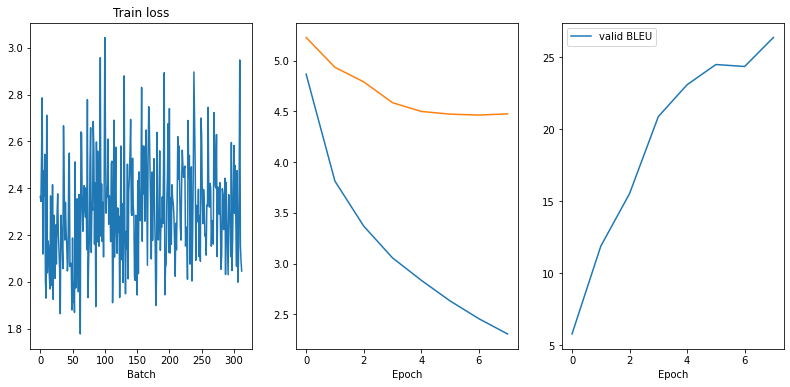

Epoch: 08 | Time: 8m 25s
	Train Loss: 2.306 | Train PPL:  10.030
	 Val. Loss: 4.476 |  Val. PPL:  87.924
	 Val. BLEU: 26.382

 -------------------------------------------------------------------------------- 

Epoch: 09
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

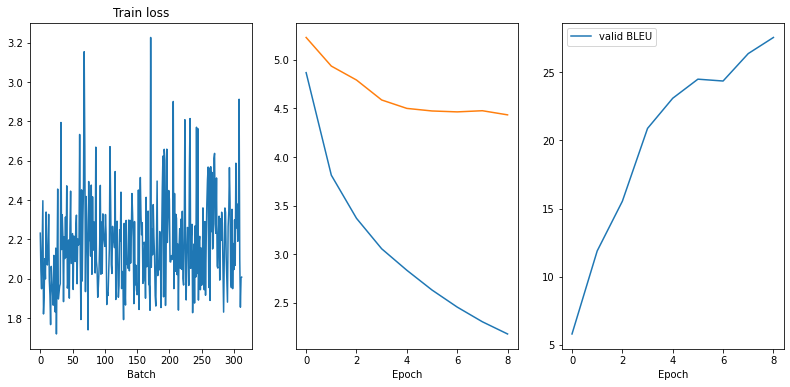

Epoch: 09 | Time: 8m 28s
	Train Loss: 2.180 | Train PPL:   8.848
	 Val. Loss: 4.434 |  Val. PPL:  84.271
	 Val. BLEU: 27.565

 -------------------------------------------------------------------------------- 

Epoch: 10
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

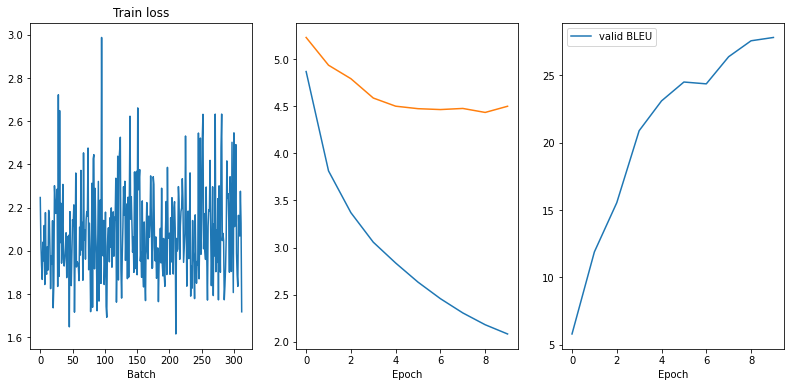

Epoch: 10 | Time: 8m 26s
	Train Loss: 2.082 | Train PPL:   8.021
	 Val. Loss: 4.500 |  Val. PPL:  89.983
	 Val. BLEU: 27.812

 -------------------------------------------------------------------------------- 

Epoch: 11
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

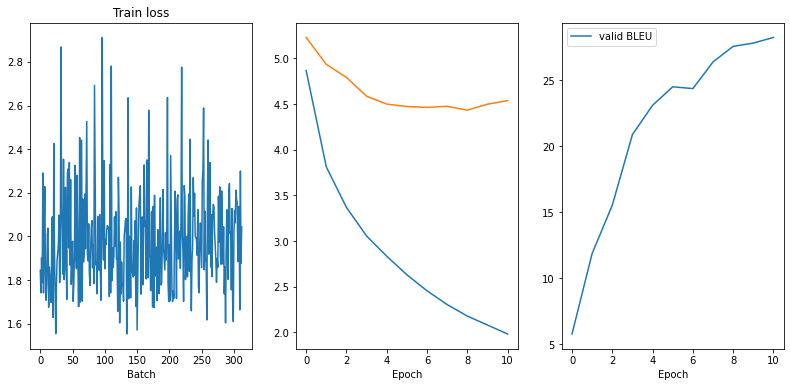

Epoch: 11 | Time: 8m 29s
	Train Loss: 1.984 | Train PPL:   7.270
	 Val. Loss: 4.538 |  Val. PPL:  93.499
	 Val. BLEU: 28.237

 -------------------------------------------------------------------------------- 

Epoch: 12
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

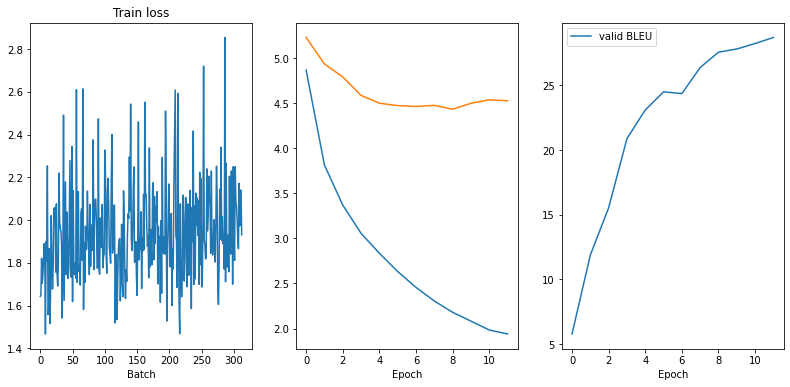

Epoch: 12 | Time: 8m 24s
	Train Loss: 1.940 | Train PPL:   6.956
	 Val. Loss: 4.527 |  Val. PPL:  92.523
	 Val. BLEU: 28.703

 -------------------------------------------------------------------------------- 

Epoch: 13
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

Calculating valid_loss


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating valid_bleu


  0%|          | 0/20 [00:00<?, ?it/s]

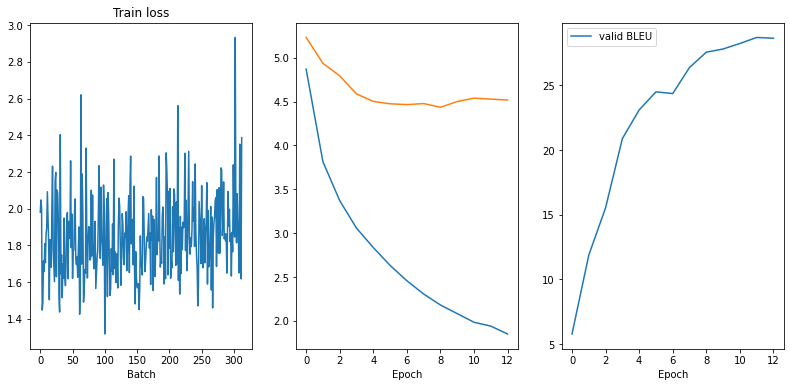

Epoch: 13 | Time: 8m 24s
	Train Loss: 1.850 | Train PPL:   6.359
	 Val. Loss: 4.517 |  Val. PPL:  91.542
	 Val. BLEU: 28.644

 -------------------------------------------------------------------------------- 

Epoch: 14
Calculating train_loss


  0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [37]:
import tqdm

if TRAIN:
    train_history = []
    valid_history = []
    valid_bleu_history = []

    N_EPOCHS = 30
    PATIENCE = 5
    CLIP = 5

    # better to optimise for BLEU on validation set if that's what we care about on 
    #   the test set
    # best_valid_loss = float('inf')

    # allowes to keep the best model saved and only substituted if better valid bleu is achieved
    print('Calculating valid bleu of the best checkpoint.')
    best_valid_bleu = evaluate_bleu(model, valid_iterator, TRG.vocab)
    print(f'Best valid bleu achieved: {best_valid_bleu:.3}')
    print('\n', '-'*80, '\n')
    
    best_epoch = 0
    current_patience = 0

    for epoch in range(N_EPOCHS):
        print(f'Epoch: {epoch+1:02}')
        
        start_time = time.time()
        
        print('Calculating train_loss')
        epochs_history, train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        print('Calculating valid_loss')
        valid_loss = evaluate(model, valid_iterator, criterion)
        print('Calculating valid_bleu')
        valid_bleu = evaluate_bleu(model, valid_iterator, TRG.vocab)
        
        # change learning rate
        sheduler.step(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        # REMEMBER TO CHECK THE SIGN
        if valid_bleu > best_valid_bleu:
            # record
            best_valid_bleu = valid_bleu
            current_patience = 0
            best_epoch = epoch
            # save
            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Attention/best-val-model.pt')
        else:
            current_patience += 1
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        valid_bleu_history.append(valid_bleu)

        # plot once every epoch
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13.5, 6))
        ax[0].plot(epochs_history, label='train loss')
        ax[0].set_xlabel('Batch')
        ax[0].set_title('Train loss')
        if train_history is not None:
            ax[1].plot(train_history, label='train loss')
            ax[1].set_xlabel('Epoch')
        if valid_history is not None:
            ax[1].plot(valid_history, label='valid loss')
        if valid_bleu_history is not None:
            ax[2].plot(valid_bleu_history, label='valid BLEU')
            ax[2].set_xlabel('Epoch')
        plt.legend()
        plt.show()
        # print once every epoch
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print(f'\t Val. BLEU: {valid_bleu:.3f}')

        # break if reached the patience
        if current_patience > PATIENCE:
            print(f"No improvement for {PATIENCE} epochs.")
            break

        print('\n', '-'*80, '\n')

    print(f'Best valid bleu = {best_valid_bleu:.3f} achieved at epoch {best_epoch+1:02}')
else:
    print('Using a pre-trained model w/o further training.')

In [39]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Attention/best-val-model.pt'))

# model.load_state_dict(torch.load('./weights/model-bleu-29-one-layer.pt'))

batch = next(iter(test_iterator))

for idx in range(10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab, SRC.vocab)

Source: стойка регистрации открыта круглосуточно .
Original: there is a 24 - hour front desk at the property .
Generated: front desk is available 24 hours a day and a 24 - hour front desk is available .

Source: стойка регистрации работает круглосуточно .
Original: you will find a 24 - hour front desk at the property .
Generated: front desk is available 24 hours a day .

Source: стойка регистрации работает круглосуточно .
Original: there is a 24 - hour front desk at the property .
Generated: front desk is available 24 hours a day .

Source: имеется бесплатная частная парковка .
Original: free private parking is available .
Generated: free private parking is available on site .

Source: поблизости работает несколько ресторанов .
Original: there are several restaurants in the surrounding area .
Generated: many restaurants can be found in the vicinity .

Source: гостям предоставляется бесплатная парковка .
Original: the property also offers free parking .
Generated: free parking is availa

In [44]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].argmax(-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:15,  3.71it/s]


In [41]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

27.020991190523713

In [42]:
val_bleu = evaluate_bleu(model, valid_iterator, TRG.vocab)
print(f'Validation BLEU {val_bleu:.3}')

  0%|          | 0/20 [00:00<?, ?it/s]

Validation BLEU 28.7


## Recommendations:
* use bidirectional RNN
* change learning rate from epoch to epoch
* when classifying the word don't forget about embedding and summa of encoders state 
* you can use more than one layer

## You will get:

* `2` points if `21 < bleu score < 23`
* `4` points if `23 < bleu score < 25`
* `7` points if `25 < bleu score < 27`
* `9` points if `27 < bleu score < 29`
* `10` points if `bleu score > 29`

When your result is checked, your 10 translations will be checked too


## Your Conclusion
* information about your the results obtained 
* difference between seminar and homework model  
** В семинаре использовалась LSTM, у меня - LSTM для энкодера, GRU для декодера  
** Еще добавил  
Learning-rate scheduler  
Early Stopping (но до него не дошел, уж очень много времени уходит)  
** Ну и качество по итогу лучше:) 28.7